### Extractive Summarization
10개의 문장으로 구성된 텍스트가 있다면,  
그 중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식
> TextRank, Text Classification

### Abstractive Summarization
원문으로부터 내용이 요약된 새로운 문장을 생성
> Natural Language Generation, NLG

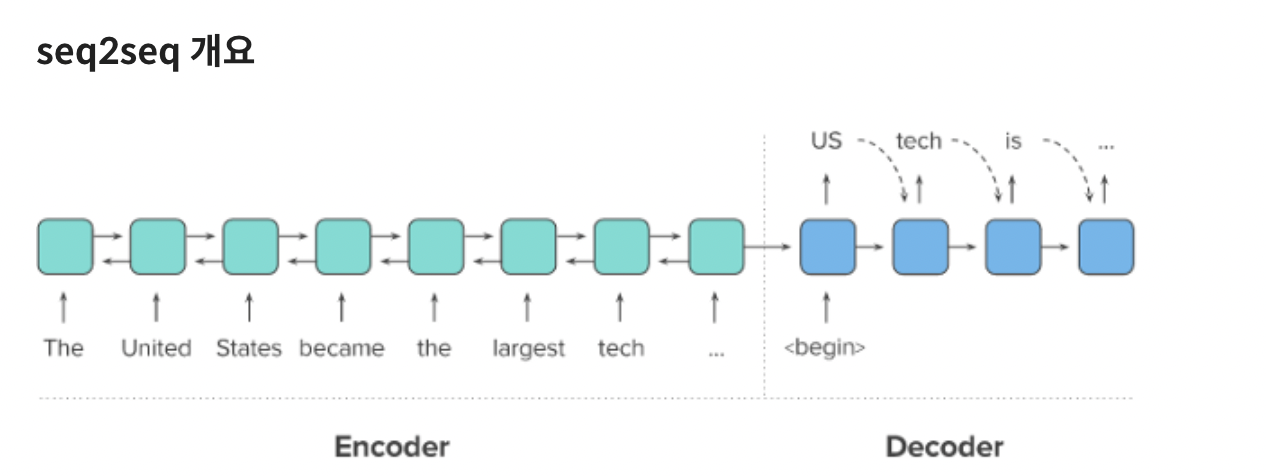
원문을 1st RNN인 Encoder로 input하면,  
Encoder는 이를 하나의 Fixed Vector로 변환해요.  

이 Vector를 문맥 정보를 가지고 있는 Vector라고 하여 context vector  
2nd RNN인 Decoder는 이 Context Vector를 전달받아 한 단어씩 생성해내서 요약 문장을 완성

https://glee1228.tistory.com/3

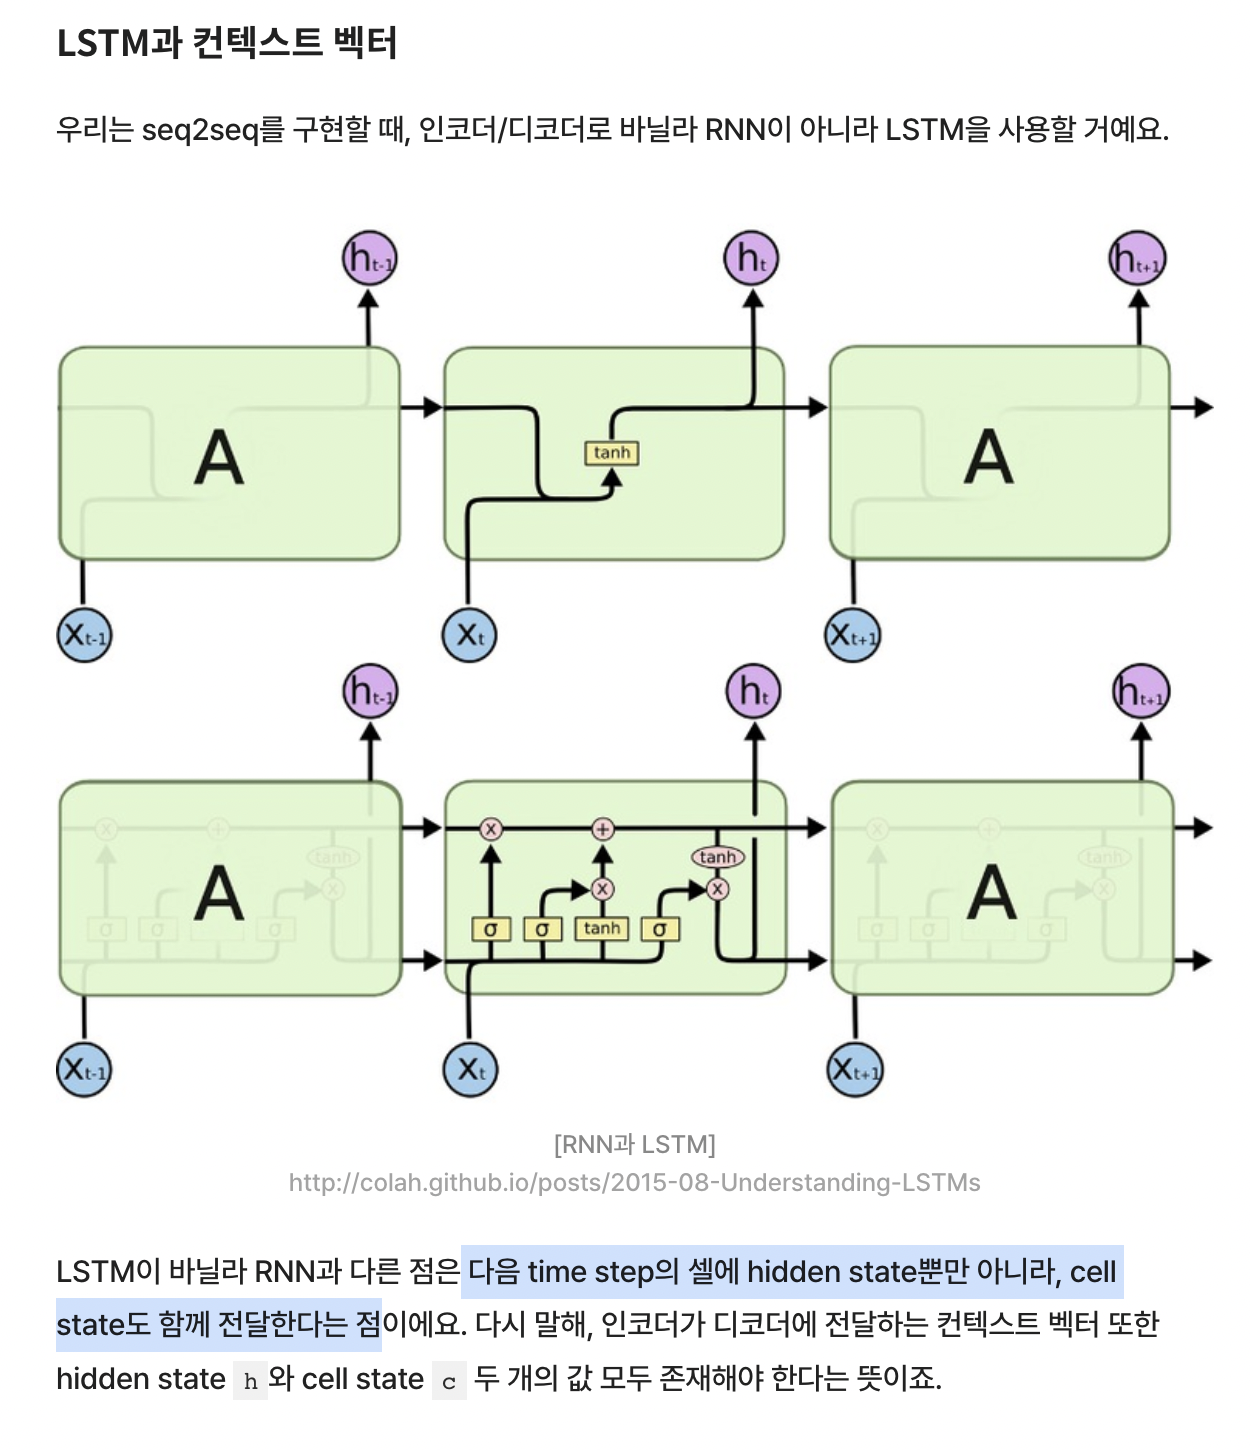

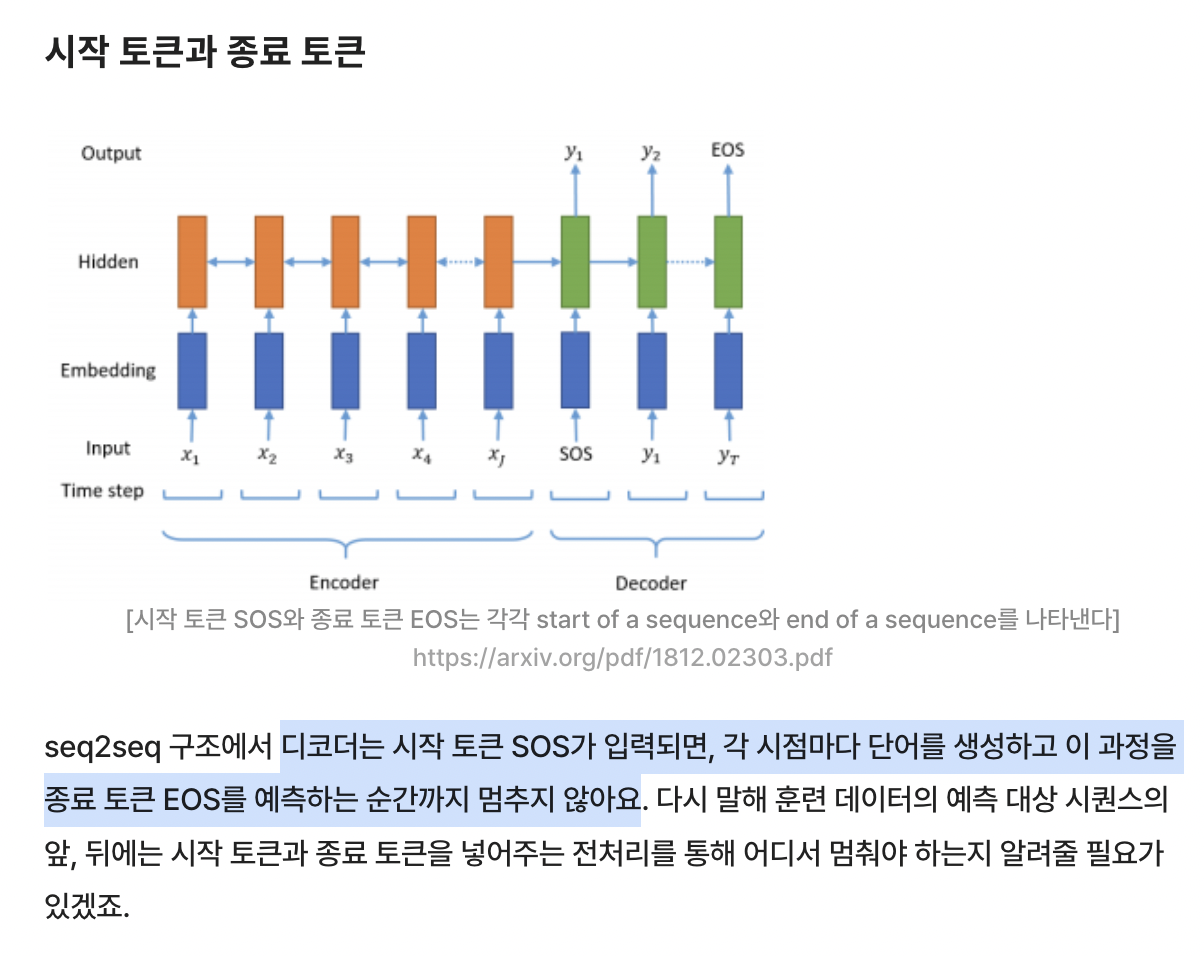

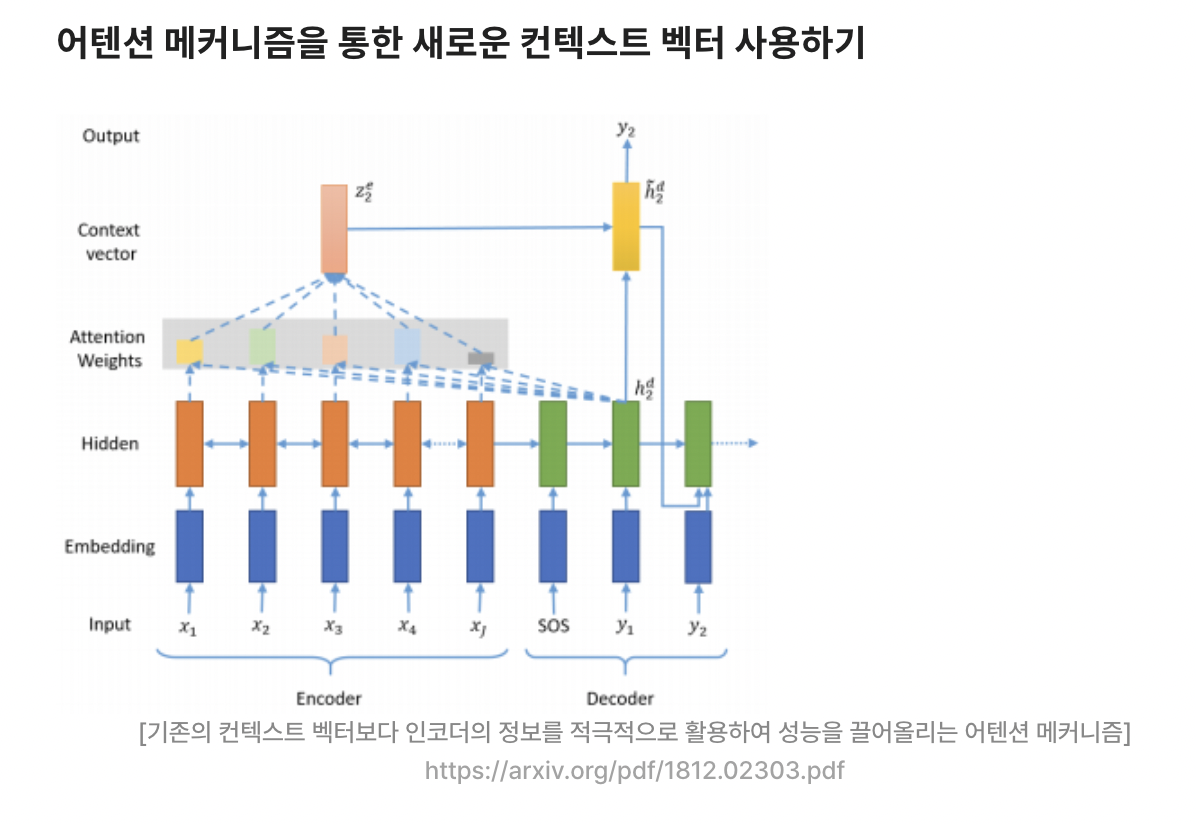
seq2seq는 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용

`Attention Mechanism` 은 이와 달리, 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것
---
Encoder의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라,  
Decoder의 현재 time step의 예측에 
Encoder의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식

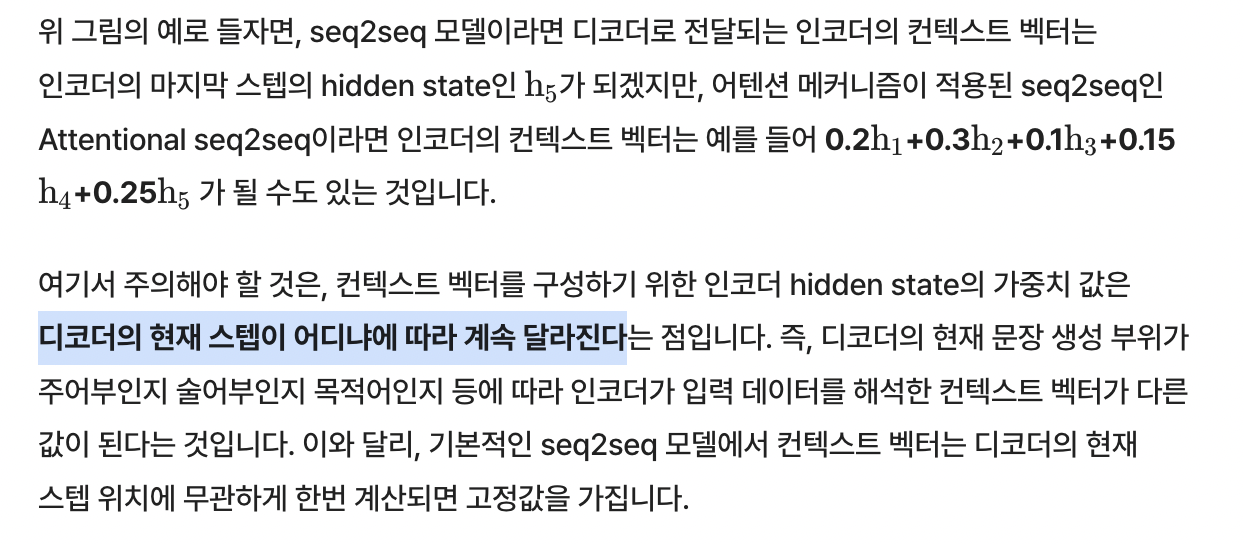

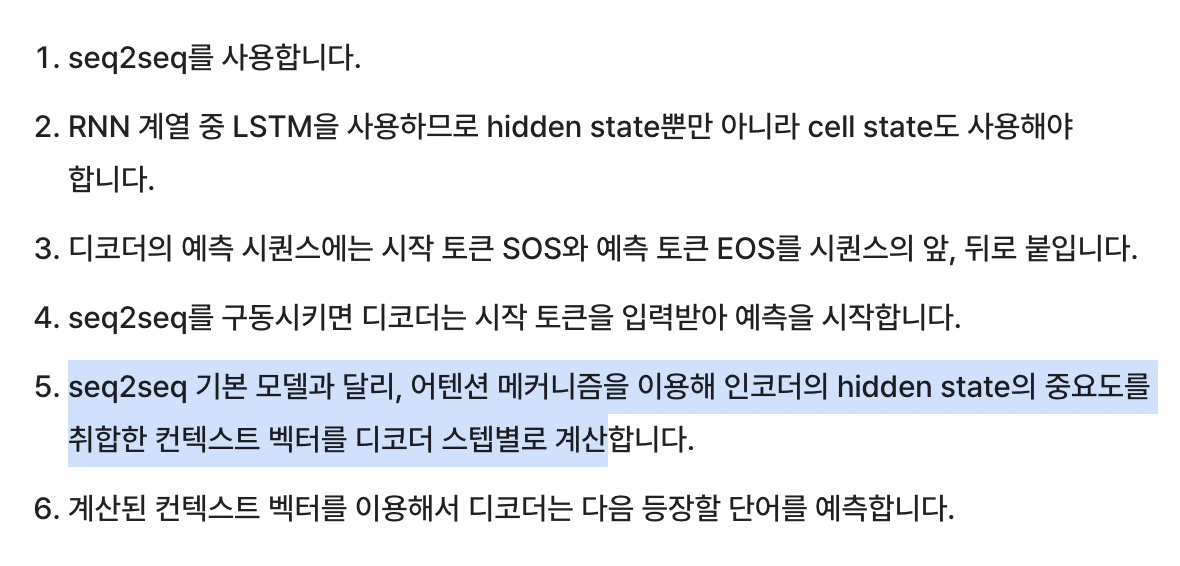

---
이번 실습에서는 NLTK의 Stop-words를 사용할 거에요.  

NLTK는 Natural Language Toolkit의 축약어로  
영어 기호, 통계, 자연어 처리를 위한 Library  
이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만,  
의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 Stop-words가 미리 정리되어 있어요.  
이를 이용해 다운로드한 리뷰 파일에서 Stop-words를 제거하는 작업을 진행할 예정이에요.

NLTK 패키지에서 불용어 사전을 다운로드하고, 데이터 전처리를 위한 나머지 패키지도 함께 불러와 볼까요.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


Reviews.csv는  
총 568,454개의 샘플을 갖고 있다.  
시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용해볼게요.

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

Text  \
85177  I received a small box of these Ginger and Hon...   
92095  First, I'll say that I made this without any m...   
57127  As you get older you need to increase your fib...   
49921  I absolutely love these. They taste so chocola...   
11786  works well as a rub on chicken<br /><br />also...   
35151  Bought this for my great-nephew and he absolut...   
19169  I drink a lot of Earl Grey tea and have tried ...   
71457  These are good but a little big to carry on a ...   
88735  Bought this as a joke to give to a friend that...   
45956  My husband and I both really like this BBQ sau...   
91198  This Starbucks French Roast K-Cup is indeed a ...   
18435  Ordered this because I've enjoyed Japanese-sty...   
66203  When my local pet store started giving out sam...   
16614  The Switch in Kiwi Berry is a good tasting car...   
23973  I love these chips!!  I am a potato chip lover...   

                                                 Summary  
85177                                          Fantastic  
92095                                     It Was Alright  
57127                                 Love the Bran Buds  
49921                                  MY FAVORITE BARS!  
11786                        great flavor - not a killer  
35151                                           good buy  
19169                    Not my favorite but pretty good  
71457                            These Are Deee-Licious!  
88735                                         Cute item!  
45956                                       Sweet Sauce!  
91198  Excellent Coffee But Somewhat Expensive - Reco...  
18435                 When they say "Mild" they mean it.  
66203           Sad to see it go, even the cat was sold!  
16614                   Tastes good. Simple ingredients.  
23973                                        great chips

Text 열의 내용을 요약한 것이 `Summary` 열이에요.  
여기서는 인공 신경망을 통해 Text 시퀀스를 입력받으면,  
Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 거예요.

---
### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외한다면  
Text에는 88,426개,  
Summary에는 72,348개의 Unique Data  
사실 이 데이터의 Summary는  
'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서  
Text가 달라도 Summary는 동일할 수 있어요.  
하지만 __Text 자체가 중복이 된 경우는 중복 샘플이므로 제거__ 해야겠죠.  

In [6]:
# Return DataFrame with duplicate rows removed.
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


만약 데이터 Null 값을 가지는 샘플이 있었다면,  
drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만,  
여전히 Null 값 1개가 어딘가 남아있을 수 있어요.  
Data에 Null 값이 남아있는지 볼게요.

In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
# axis: 'Axis' = 0,
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


### 텍스트 정규화와 불용어 제거

살아남은 88,425개의 샘플에는 수많은 단어들이 있어요.  
it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이죠.  
이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는  
기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법  
-> text normalization

In [63]:
# from nltk.corpus import stopwords
# (fileids=None, ignore_lines_startswith='\n')
stopwords.words??
#  'abspath',
#  'abspaths',
#  'citation',
#  'encoding',
#  'ensure_loaded',
#  'fileids',
#  'license',
#  'open',
#  'raw',
#  'readme',
#  'root',
#  'words']

In [9]:
# (단어의) 축약형
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때  
실질적으로 별 도움이 되지 않는 단어들이 존재  
-> Stopwords  
때로는 Stopwords를 제거하는 것이 자연어 처리의 성능을 높이는 방법  
여기서는 NLTK에서 제공하는 Stopwords 리스트를 참조해, 샘플에서 Stopwords를 제거

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 Stopwords는 총 179개라는 것을 볼 수 있죠.  
이를 사용하여 Stopwords를 제거할 거예요.  
이 작업 외에도 모든 영어 문자는 소문자로 만들고,  
섞여있는 html 태그를 제거하고,  
정규 표현식을 통해 각종 특수문자를 제거해서 
정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

---
함수의 하단을 보면, NLTK를 이용해 Stopwords를 제거하는 파트가 있는데,  
이는 Text 전처리 시에서만 호출하고  
이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요.  

Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면  
이 Stopwords들이 Summary에는 남아 있는 게 더 좋을 것 같습니다.  
이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.

In [67]:
BeautifulSoup.text?
# BeautifulSoup(
#     markup='',
#     features=None,
#     builder=None,
#     parse_only=None,
#     from_encoding=None,
#     exclude_encodings=None,
#     **kwargs,
# )
# Docstring:     
# This class defines the basic interface called by the tree builders.

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text 
    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) 
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) 
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) 
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords: # if True:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [ ]:
# for t in sentence.split(" "): # 매개변수인 sentence를 각각 분리시킨다.
#     if t in contractions: # 단어 축약어 "didn't": "did not"
#         contractions[t]
#     else:
#          t
# ' '.join[somethings]
# ---
         
# for word in sentence.split():
#          if not word in stopwords.words('english'):
#              word
#          if len(word) > 1:
#              word
# tokens =' '.join         

# ---
         
# for word in sentence.split():
#          if len(word) > 1
# tokens = ' '.join

In [12]:
temp_text = 'Everything I bought was great,\
            infact I ordered twice and the third ordered was<br />\
            for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  
# 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고,  
`<br />`과 같은 html 태그가 제거되었죠.  
(or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요.   
또한 특수문자가 제거되면서 영어만 남았어요.  
> `br -> break`  
https://heinafantasy.com/67

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65818 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            65818 non-null  object
 1   Summary         65818 non-null  object
 2   decoder_input   65818 non-null  object
 3   decoder_target  65818 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [75]:
data.head()

Text                Summary  \
0  bought several vitality canned dog food produc...  good quality dog food   
1  product arrived labeled jumbo salted peanuts p...      not as advertised   
2  confection around centuries light pillowy citr...    delight says it all   
3  looking secret ingredient robitussin believe f...         cough medicine   
4  great taffy great price wide assortment yummy ...            great taffy   

                    decoder_input                  decoder_target  
0  sostoken good quality dog food  good quality dog food eostoken  
1      sostoken not as advertised      not as advertised eostoken  
2    sostoken delight says it all    delight says it all eostoken  
3         sostoken cough medicine         cough medicine eostoken  
4            sostoken great taffy            great taffy eostoken

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))# 데이터 전처리 함수

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [14]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [77]:
clean_summary[-5:] # 88425

['yummy',
 'tastes like more',
 'great ramen',
 'spicy',
 'this spicy noodle cures my cold upset stomach and headache every time']

In [80]:
data.tail()

Text      Summary  \
99993  stuff awesome best flavor boil water drain wat...  great stuff   
99994               love noodle little spicy wife perfct   good stuff   
99995                 love buy another box done last one        yummy   
99997  favorite brand korean ramen spicy used eating ...  great ramen   
99998  like noodles although say spicy somewhat under...        spicy   

              decoder_input        decoder_target  
99993  sostoken great stuff  great stuff eostoken  
99994   sostoken good stuff   good stuff eostoken  
99995        sostoken yummy        yummy eostoken  
99997  sostoken great ramen  great ramen eostoken  
99998        sostoken spicy        spicy eostoken

이렇게 텍스트 정제의 과정을 거친 후에는  
다시 한번 empty 샘플이 생겼는지 확인해보는 것이 좋아요.  
정제 전에는 데이터가 존재했지만,  
정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요.  
이렇게 되면 샘플 자체가 empty 값을 가지게 되겠죠.  

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요.  
empty 값을 가진 샘플들이 있다면,  
모두 Null 값을 가진 샘플로 대체해요.

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

Summary 열에서 70개의 Null 값이 생겼네요.  
원래는 단어가 있었는데,  
정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미예요.  
이 샘플들은 모두 제거해줄게요.  

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


### 9-6. 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는  
학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 해요.
### 샘플의 최대 길이 정하기

`plt.tight_layout`(*, pad=1.08, h_pad=None, w_pad=None, rect=None)  
Docstring:  
Adjust the padding between and around subplots.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


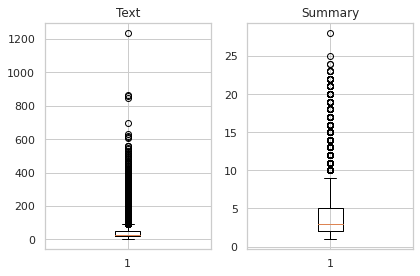

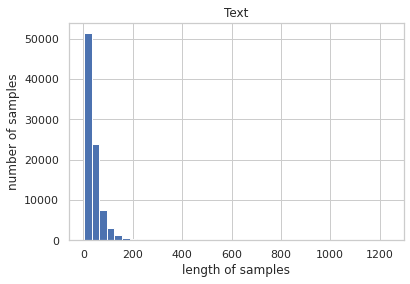

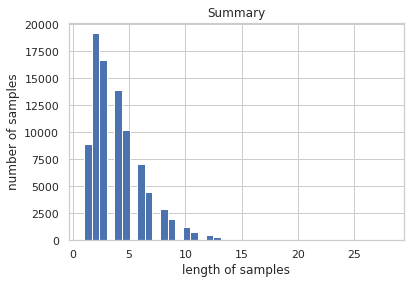

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 단어 단위로 분리해서 해당 문장의 단어의 갯수를 길이로 잡았네
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요.

그래프는 각각 실제 텍스트와 요약의 길이 분포,  
실제 텍스트 샘플 길이별 개수,  
요약본 샘플 길이별 개수를 나타내고 있어요

---
`Text`  
min 길이가 2, max 길이가 1,235로 그 차이가 굉장히 크죠.  
하지만 mean 길이는 38  
시각화된 그래프로 봤을 때는  
대체적으로는 100 내외의 길이  

`Summary`  
min 길이가 1, max 길이가 28,  
그리고 mean 길이가 4 (Text에 비해 상대적으로 길이가 매우 짧아요.)  
그래프로 봤을 때에도  
대체적으로 10이하의 길이  

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요

In [19]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


각각 50과 8로 정했는데 이 길이를 선택했을 때,  
얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지  
통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요.  
train data와 sample의 길이를 입력하면,  
데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.  

In [20]:
def below_threshold_len(max_len, nested_list): 
  cnt = 0
  for s in nested_list: # data['Text']
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게 되면   
해당 길이보다 긴 샘플들은 내용이 잘리게 되는데,  
Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라,  
정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


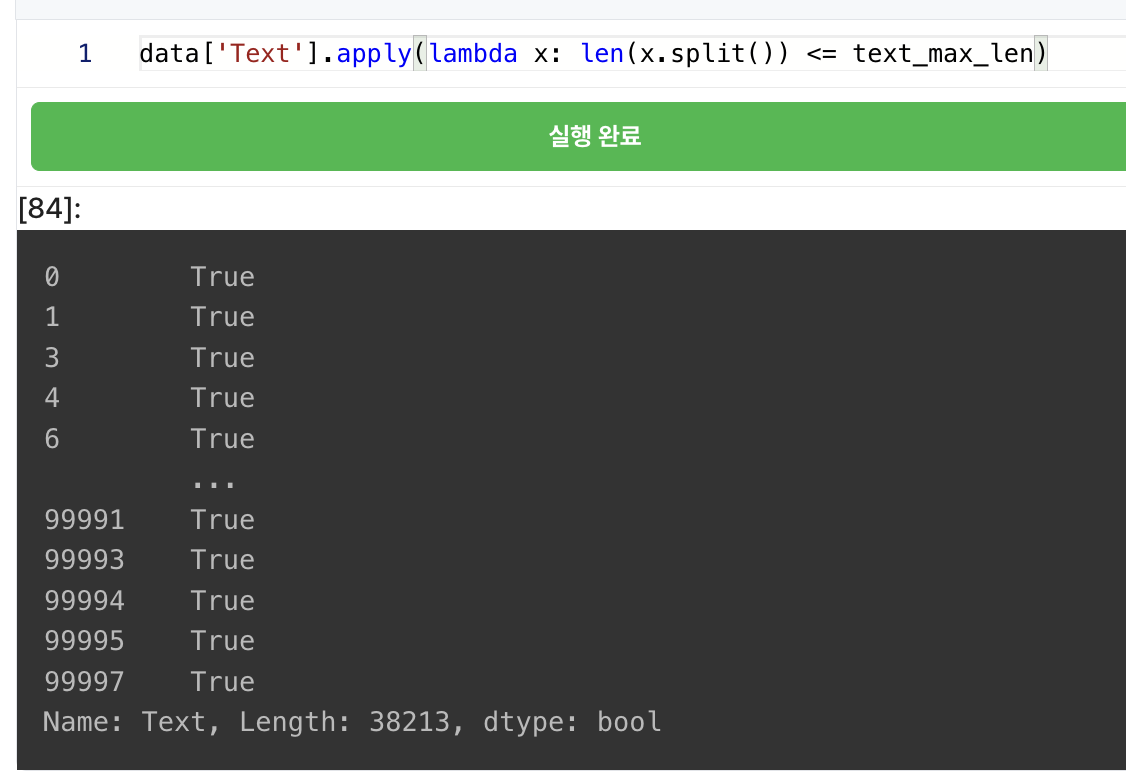

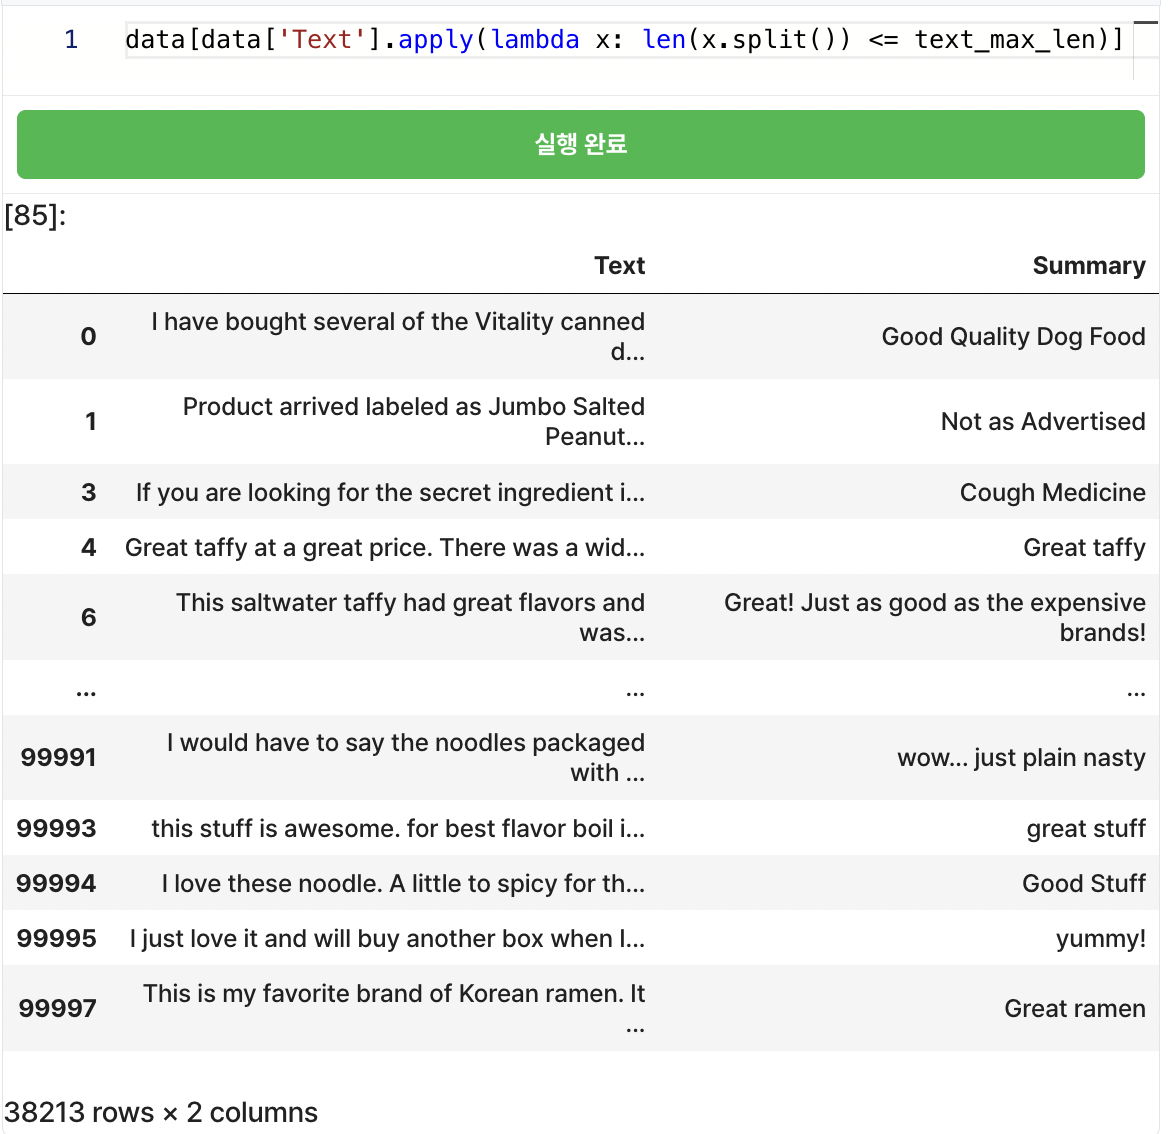

'Text'열에서 걸러내고 'Summary'열에서 걸러내고

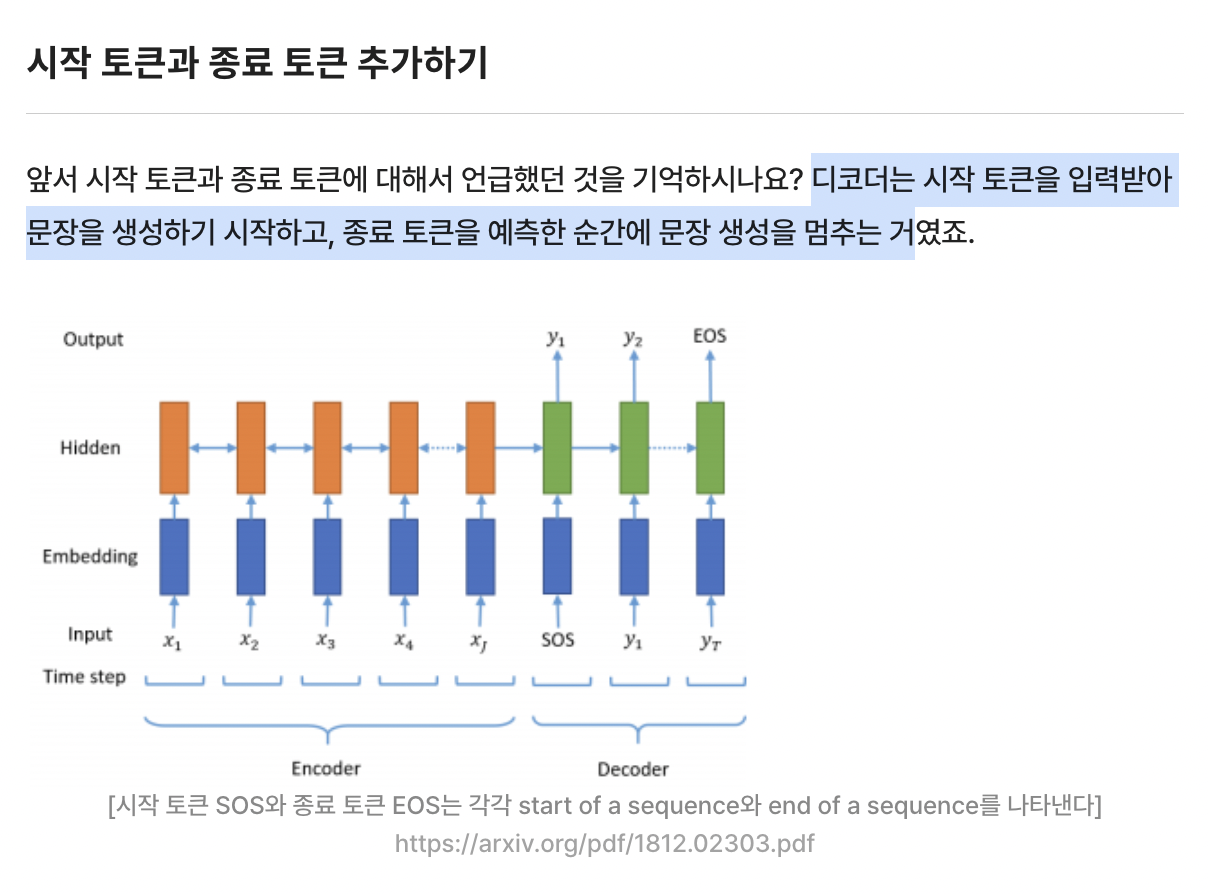

Decoder의 input에 해당하면서 Start token이 맨 앞에 있는 문장의 이름을 `decoder_input`열 개설   
Decoder의 output 또는 레이블에 해당되면서 End token이 맨 뒤에 붙는 문장의 이름을 `decoder_target`열 개설

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

Text                Summary  \
0  bought several vitality canned dog food produc...  good quality dog food   
1  product arrived labeled jumbo salted peanuts p...      not as advertised   
2  confection around centuries light pillowy citr...    delight says it all   
3  looking secret ingredient robitussin believe f...         cough medicine   
4  great taffy great price wide assortment yummy ...            great taffy   

                    decoder_input                  decoder_target  
0  sostoken good quality dog food  good quality dog food eostoken  
1      sostoken not as advertised      not as advertised eostoken  
2    sostoken delight says it all    delight says it all eostoken  
3         sostoken cough medicine         cough medicine eostoken  
4            sostoken great taffy            great taffy eostoken

In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [86]:
encoder_input.shape, decoder_target.shape

((65818,), (65818,))

In [83]:
decoder_target # 65818개의 문장
#오... 이렇게 변하구낭

array(['makes great southwestern margarita eostoken',
       'good for pink gin eostoken', 'english loose tea eostoken', ...,
       'good low sodium bouillon eostoken',
       'too much like pringles did not like them eostoken',
       'superior product gmo free eostoken'], dtype=object)

### 이제 훈련 데이터와 테스트 데이터를 분리할거에요
encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[18886 14207 13630 ... 34804 37068   844]


In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요.  
전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


# 9-7. 데이터 전처리하기 (3) 정수 인코딩
단어 집합(vocabulary) 만들기 및 정수 인코딩

Tokenizer(
    num_words=None, 10,000  
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', " "  
    lower=True,  
    split=' ',  
    char_level=False, -> 단어단위, True -> alpabet 단위  
    oov_token=None, "<unk>"  
    document_count=0,  
    **kwargs,  

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# Updates internal vocabulary based on a list of texts.
print('=3')

=3


In [87]:
# 이제 단어 집합이 생성되는 동시에 `각 단어에 고유한 정수`가 부여되었어요.  
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요.
src_tokenizer.word_index 
# 31966

{'like': 1,
 'good': 2,
 'great': 3,
 'taste': 4,
 'product': 5,
 'love': 6,
 'one': 7,
 'coffee': 8,
 'flavor': 9,
 'would': 10,
 'tea': 11,
 'really': 12,
 'get': 13,
 'amazon': 14,
 'best': 15,
 'price': 16,
 'buy': 17,
 'much': 18,
 'food': 19,
 'time': 20,
 'use': 21,
 'little': 22,
 'find': 23,
 'tried': 24,
 'better': 25,
 'also': 26,
 'well': 27,
 'make': 28,
 'chocolate': 29,
 'dog': 30,
 'try': 31,
 'eat': 32,
 'even': 33,
 'bought': 34,
 'delicious': 35,
 'found': 36,
 'order': 37,
 'could': 38,
 'sweet': 39,
 'cup': 40,
 'tastes': 41,
 'recommend': 42,
 'drink': 43,
 'used': 44,
 'loves': 45,
 'bag': 46,
 'cannot': 47,
 'sugar': 48,
 'favorite': 49,
 'store': 50,
 'first': 51,
 'free': 52,
 'nice': 53,
 'made': 54,
 'way': 55,
 'box': 56,
 'go': 57,
 'got': 58,
 'perfect': 59,
 'dogs': 60,
 'mix': 61,
 'easy': 62,
 'ordered': 63,
 'day': 64,
 'since': 65,
 'think': 66,
 'water': 67,
 'snack': 68,
 'hot': 69,
 'bit': 70,
 'ever': 71,
 'flavors': 72,
 'give': 73,
 'two': 74,


그런데 우리는 이렇게 만든 단어 집합에 있는  
모든 단어를 사용하는 것이 아니라,  
빈도수가 낮은 단어들은  
train data에서 제외하고 진행하려고 해요.  

등장 빈도수가 7회 미만인 단어들이  
이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.   

src_tokenizer.word_counts.items()에는  
단어와 각 단어의 등장 빈도수가 저장돼 있는데,  
이를 통해서 통계적인 정보를 얻을 수 있어요.

In [88]:
src_tokenizer.word_counts # .items()

OrderedDict([('first', 3055),
             ('southwestern', 7),
             ('margarita', 17),
             ('months', 1009),
             ('back', 1709),
             ('restaurant', 213),
             ('recreate', 7),
             ('home', 1165),
             ('good', 14813),
             ('time', 5182),
             ('fine', 960),
             ('tuning', 2),
             ('recipe', 535),
             ('even', 3895),
             ('errors', 2),
             ('delicious', 3488),
             ('product', 10663),
             ('shipped', 591),
             ('quickly', 977),
             ('shape', 286),
             ('coat', 158),
             ('glass', 299),
             ('bitters', 17),
             ('dump', 52),
             ('excess', 26),
             ('add', 2052),
             ('gin', 16),
             ('know', 2238),
             ('reason', 556),
             ('buy', 5785),
             ('sure', 1803),
             ('loose', 302),
             ('tea', 8098),
             ('much',

In [91]:
len(src_tokenizer.word_index)

31966

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31966
등장 빈도가 6번 이하인 희귀 단어의 수: 23691
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8275
단어 집합에서 희귀 단어의 비율: 74.11312019020208
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3692896500325373


In [93]:
total_freq, rare_freq, rare_cnt

(232170, 13751, 8148)

In [95]:
encoder_input_train.

(51373, 50)

encoder_input_train에는 3만여 개의 단어가 있네요.  
그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만,  
즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요.  
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은  
상대적으로 적은 수치인 3.39%밖에 되지 않아요.

---
그래서 `등장 빈도가 6회 이하인 단어들`은 (rare_cnt가 약 8천)  
정수 인코딩 과정에서 빼고, train data에서 제거하고자 합니다.  
위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데,  
이와 비슷한 값으로 어림잡아 `단어 집합의 크기를 8,000으로 제한`해볼게요.  

In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


`texts_to_sequences()`는 생성된 단어 집합에 기반하여  
입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요.  
현재 단어 집합의 크기를 8,000으로 제한했으니까  
이제 8,000이 넘는 숫자들은 정수 인코딩 후에는  
데이터에 존재하지 않아요.

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[51, 7674, 4919, 246, 132, 987, 7675, 209, 2, 20, 262, 444, 33, 35, 5, 406, 256, 262, 784], [1239, 755, 4920, 2612, 3903, 99, 5061, 83, 430, 17, 120], [749, 11, 18, 25, 11, 145, 74, 143, 78, 206, 402, 91, 33, 376, 40, 13, 221, 2132, 551, 43, 48, 297]]


Summary 데이터에 대해서도 동일한 작업을 수행할게요.  
keras.Tokenizer를 사용하여 decoder_input_train을 입력으로  
전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요.  
이는 tar_tokenizer.word_index에 저장되어 있어요.  
tar_tokenizer.word_counts.items()에는  
단어와 각 단어의 등장 빈도수가 저장돼 있는데,  
이를 통해서 통계적인 정보를 얻어서,  
등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10525
등장 빈도가 5번 이하인 희귀 단어의 수: 8148
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2377
단어 집합에서 희귀 단어의 비율: 77.41567695961994
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.9228151785329715


등장 빈도가 5회 이하인 단어들은 단어 집합에서  
약 77%를 차지하고 있네요.  
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은  
상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요.  
아까 했던 것과 동일하게 이 단어들은 모두 제거할게요.  
어림잡아 2,000을 단어 집합의 크기로 제한할게요.  

---
num_words: the maximum number of words to keep, based on word frequency. 단어 빈도가 많은 순서대로  
https://han-py.tistory.com/284

In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 165, 3], [1, 4, 8, 1114], [1, 521, 686, 14], [1, 1171], [1, 387, 10, 6, 166, 5, 30]]
target
decoder  [[165, 3, 2], [4, 8, 1114, 2], [521, 686, 14, 2], [1171, 2], [387, 10, 6, 166, 5, 30, 2]]


정상적으로 정수 인코딩 작업이 끝났어요.  
현재 decoder_input_train과 decoder_target_train에는  
더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요.  
그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은  
빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 empty 샘플이 되었을 가능성이 있어요.  
이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만,  
애초에 평균 길이가 4밖에 되지 않았던 Summary의 경우에는  
이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요.  
여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고,  
이 두 토큰은 모든 샘플에서 등장하므로  
빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요.  
그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요.  
길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의  
인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요.  
이 샘플들은 모두 삭제할 거예요.

In [36]:
# 문장의 길이가 1인 해당 index만 모은당
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 문장 길이가 1이 아닌 index만 즉, 문장 길이가 2이상만 모은당.
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1282
삭제할 테스트 데이터의 개수 : 310
훈련 데이터의 개수 : 51373
훈련 레이블의 개수 : 51373
테스트 데이터의 개수 : 12853
테스트 레이블의 개수 : 12853


# 패딩하기 
텍스트 시퀀스를 정수 시퀀스로 변환했다면,  
이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해  
같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요.  
아까 정해두었던 최대 길이로 패딩 해 줄 거에요.  
max 길이보다 짧은 데이터들은  
(post)뒤의 공간에 숫자 0을 넣어 max 길이로 길이를 맞춰줄게요.

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, 
                                    maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, 
                                   maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, 
                                    maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, 
                                     maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, 
                                   maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, 
                                    maxlen=summary_max_len, padding='post')
print('=3')

=3


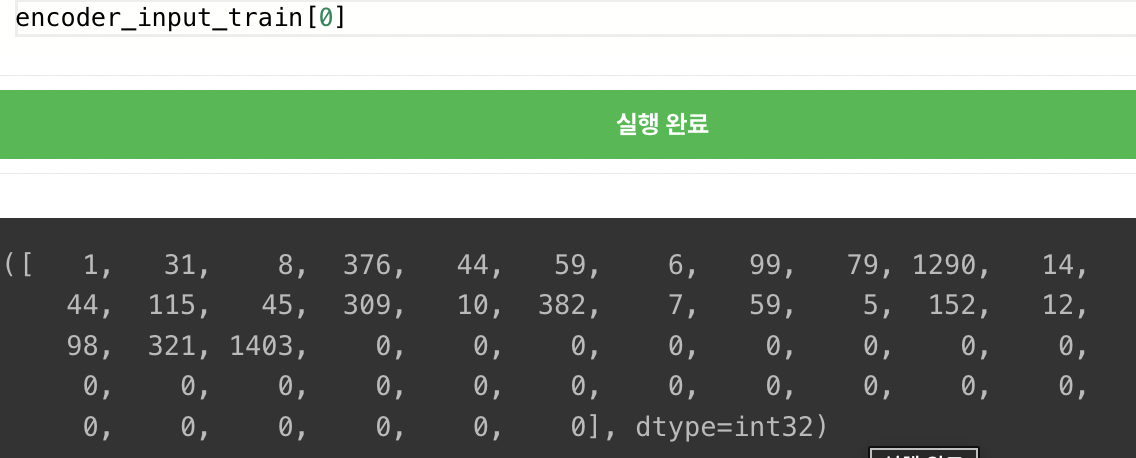

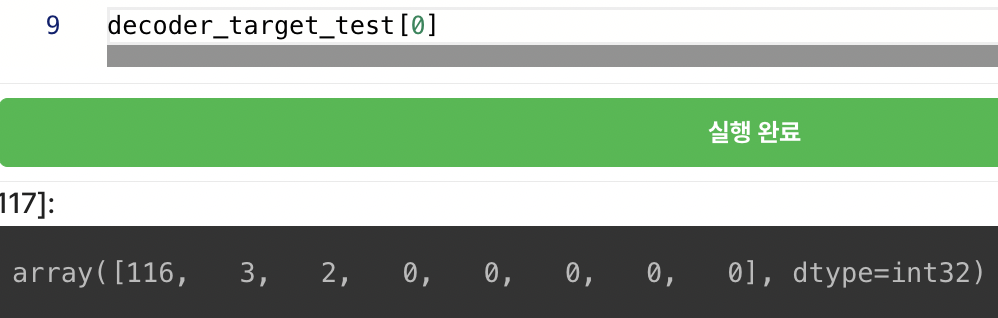

# 9-8. 모델 설계하기

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1  recurrent_dropout = 0.4
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, 
                     return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, 
                     return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, 
                     return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고,  
hidden state의 크기를 256으로 정의했어요.  

hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요.  
이 파라미터는 LSTM의 용량의 크기나,  
LSTM에서의 뉴런의 개수라고 이해하면 돼요.  

다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요.  
hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면,  
3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠.  
3개의 층을 지나서 Encoder로부터 나온 출력 벡터는 Decoder로 보내줘야겠죠?  

또한 LSTM은 `dropout` 뿐 아니라 `recurrent dropout`까지 사용할 수 있어요.  
일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 overfitting을 해결해주는 방법이에요.

반면 `recurrent dropout`은 dropout을 레이어가 아닌  
`time step마다` 해주는 방식이에요.  
즉 time step의 입력을 `랜덤으로 생략`해 주는 거죠.  
recurrent dropout은 일반적인 dropout와 같이  
`regularization을 해주는 효과`가 있고, `과적합을 방지`할 수 있다고 해요.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다.  
색이 있는 화살표는 dropout을 나타낸 것이에요.  
(색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가셔도 됩니다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다.  
그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요.  
참고로 dropout과 recurrent dropout을 모두 사용한 것을  
->Variational Dropout이라고도 해요.

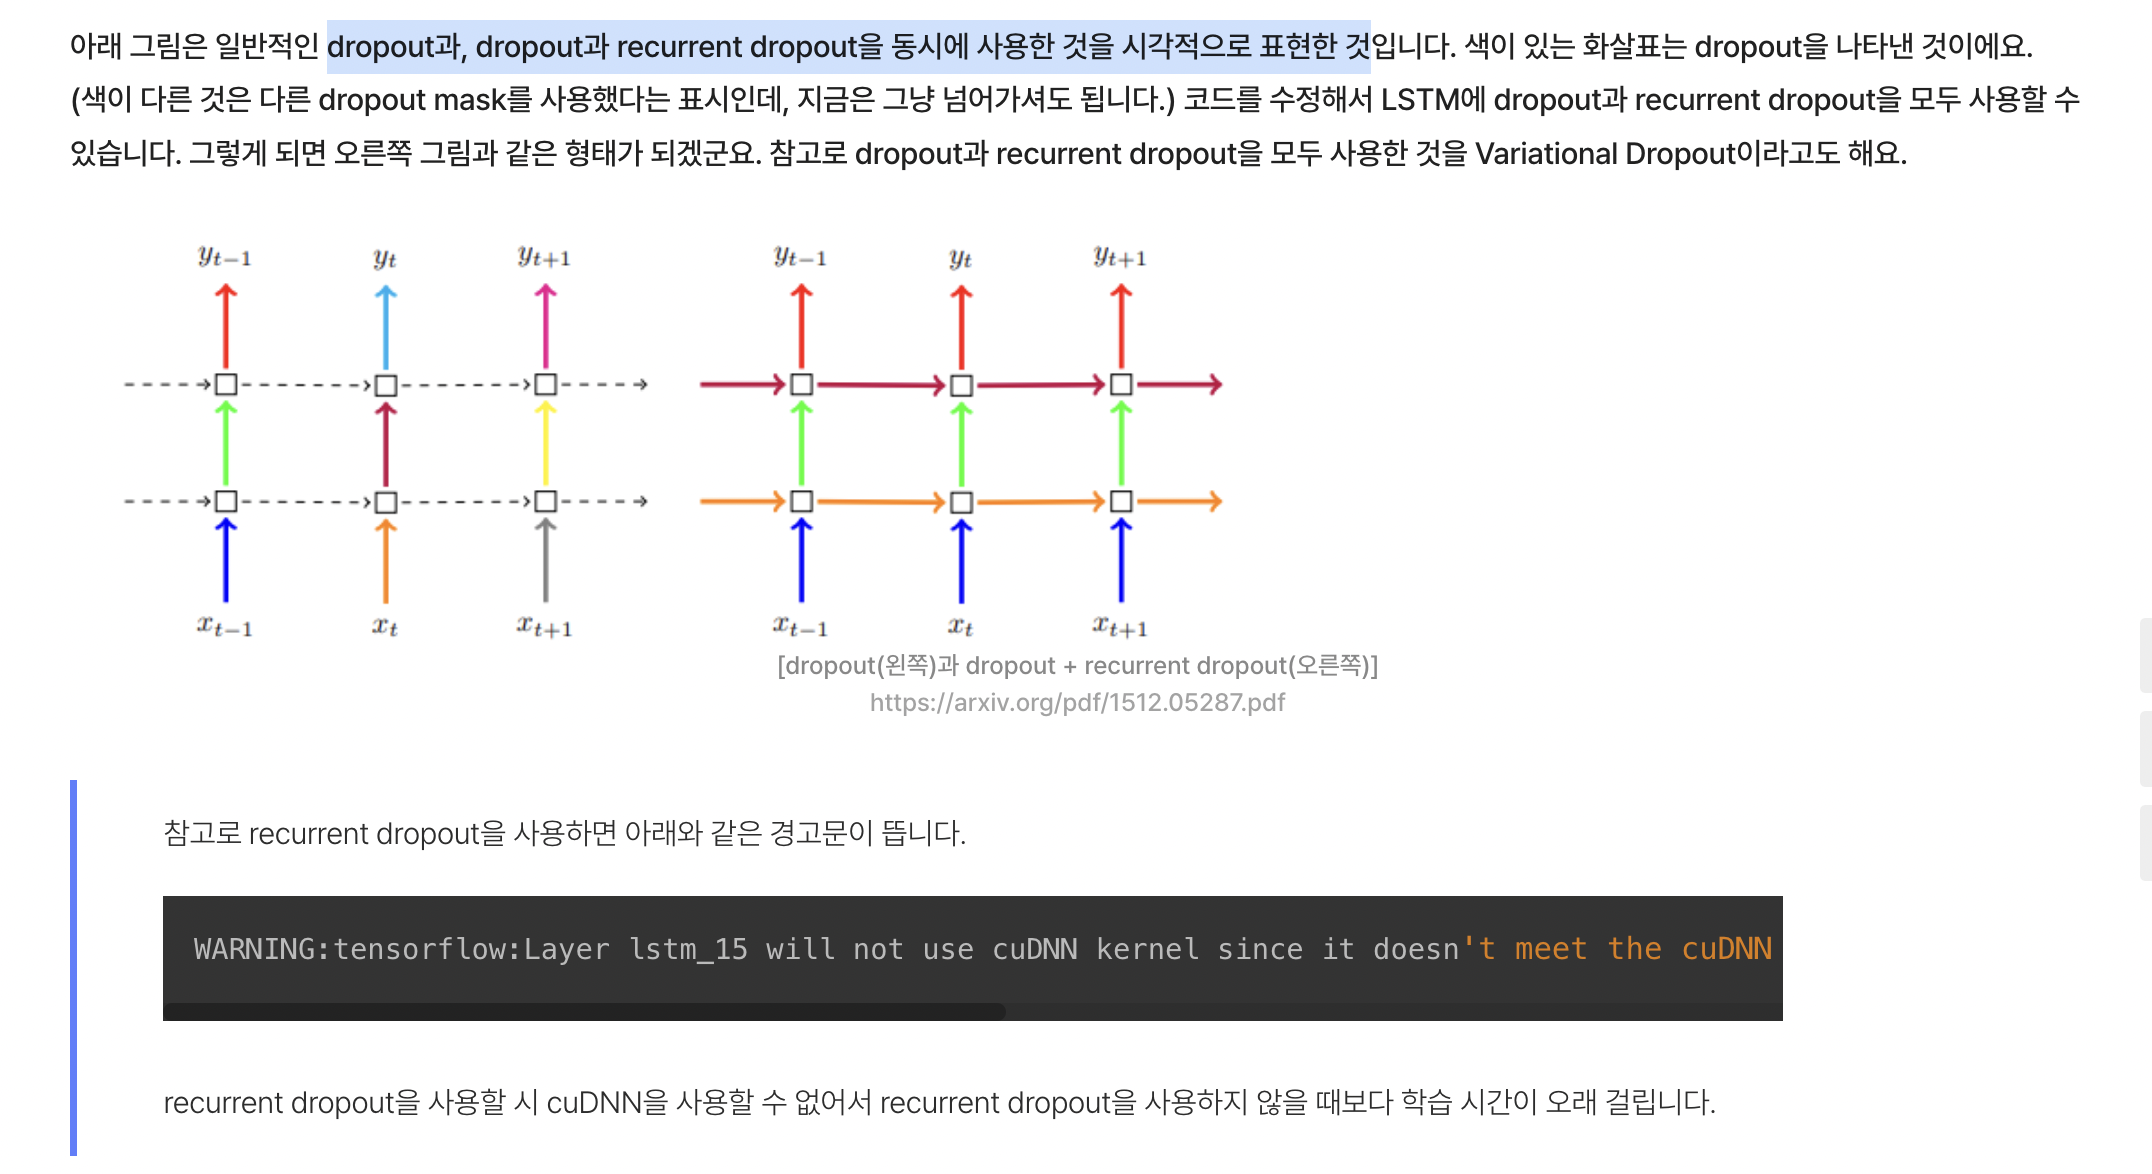
https://arxiv.org/pdf/1603.05118v2.pdf

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, 
                    return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, 
                                     initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요.  
하지만 LSTM의 입력을 정의할 때,  
initial_state의 인자값으로  
Encoder의 hidden state와 cell state의 값을 넣어줘야 해요.

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인  
tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는  
multi class classification를 풀어야 해요.  
그렇기 때문에 Dense의 인자로 tar_vocab을 주고,  
Activation function로 Softmax 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를  
Decoder의 초기 state로 사용하는 가장 기본적인 seq2seq에요.  
그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요!  
`Attention Mechanism`

### Attention Mechanism
https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과  
디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,  
어텐션 함수가 리턴한 값을 예측 시에  
디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

In [99]:
# keras.layers.Concatenate??

Object `keras.layers.Concatenate` not found.


# 9-9. 모델 훈련하기

In [42]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], 
                    y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], 
                           decoder_target_test), \
          batch_size=256, callbacks=[es], 
                    epochs=50)

Epoch 1/50
201/201 [==============================] - 22s 77ms/step - loss: 2.7018 - val_loss: 2.4131
Epoch 2/50
201/201 [==============================] - 14s 72ms/step - loss: 2.3663 - val_loss: 2.2729
Epoch 3/50
201/201 [==============================] - 14s 70ms/step - loss: 2.2313 - val_loss: 2.1533
Epoch 4/50
201/201 [==============================] - 14s 70ms/step - loss: 2.1124 - val_loss: 2.0658
Epoch 5/50
201/201 [==============================] - 14s 69ms/step - loss: 2.0297 - val_loss: 2.0141
Epoch 6/50
201/201 [==============================] - 14s 70ms/step - loss: 1.9676 - val_loss: 1.9803
Epoch 7/50
201/201 [==============================] - 14s 71ms/step - loss: 1.9152 - val_loss: 1.9506
Epoch 8/50
201/201 [==============================] - 14s 70ms/step - loss: 1.8676 - val_loss: 1.9221
Epoch 9/50
201/201 [==============================] - 14s 70ms/step - loss: 1.8250 - val_loss: 1.9049
Epoch 10/50
201/201 [==============================] - 14s 70ms/step - loss: 1.786

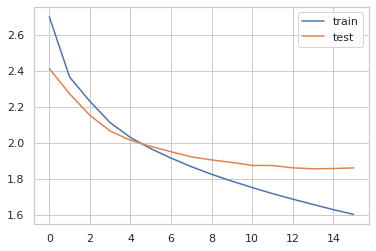

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 9-10. 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로,  
필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [44]:
src_index_to_word = src_tokenizer.index_word 
# ['Text'] 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index 
# ["Summary"] 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word 
# ["Summary"] 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [101]:
tar_word_to_index

{'sostoken': 1,
 'eostoken': 2,
 'great': 3,
 'good': 4,
 'the': 5,
 'not': 6,
 'best': 7,
 'for': 8,
 'love': 9,
 'and': 10,
 'it': 11,
 'my': 12,
 'coffee': 13,
 'tea': 14,
 'this': 15,
 'product': 16,
 'delicious': 17,
 'but': 18,
 'is': 19,
 'taste': 20,
 'very': 21,
 'to': 22,
 'of': 23,
 'excellent': 24,
 'dog': 25,
 'yummy': 26,
 'flavor': 27,
 'these': 28,
 'tasty': 29,
 'price': 30,
 'like': 31,
 'ever': 32,
 'favorite': 33,
 'in': 34,
 'food': 35,
 'too': 36,
 'stuff': 37,
 'snack': 38,
 'loves': 39,
 'so': 40,
 'awesome': 41,
 'dogs': 42,
 'on': 43,
 'with': 44,
 'are': 45,
 'healthy': 46,
 'just': 47,
 'as': 48,
 'yum': 49,
 'chocolate': 50,
 'better': 51,
 'you': 52,
 'free': 53,
 'perfect': 54,
 'wonderful': 55,
 'no': 56,
 'nice': 57,
 'them': 58,
 'tastes': 59,
 'have': 60,
 'treat': 61,
 'really': 62,
 'quality': 63,
 'than': 64,
 'what': 65,
 'tasting': 66,
 'treats': 67,
 'sweet': 68,
 'bad': 69,
 'hot': 70,
 'at': 71,
 'buy': 72,
 'amazing': 73,
 'popcorn': 74,
 'li

seq2seq는 training할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로  
그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?  

training 단계에서는 Decoder의 입력부에  
정답이 되는 문장 전체를 한꺼번에 넣고 Decoder의 출력과 한 번에 비교할 수 있으므로,  
Encoder와 Decoder를 엮은 통짜 모델 하나만 준비했습니다.  

그러나 정답 문장이 없는 인퍼런스 단계에서는  
만들어야 할 문장의 길이만큼 Decoder가 반복 구조로 동작해야 하기 때문에  
부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다.  
이때는 Encoder 모델과 Decoder 모델을 분리해서 설계합니다.  

In [103]:
encoder_outputs, state_h, state_c

(<KerasTensor: shape=(None, 50, 256) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_2')>)

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [106]:
decoder_hidden_state_input, attn_out_inf, decoder_inf_concat

(<KerasTensor: shape=(None, 50, 256) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'attention_layer')>,
 <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'concat')>)

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, 
                           decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [107]:
decoder_model

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len -1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# 9-11. 모델 테스트하기
함수를 만들 때,  
Text의 정수 시퀀스에서는 padding을 위해 사용되는 숫자 0을 제외하고  
Summary의 정수 시퀀스에서는 숫자 0,  
시작 토큰의 인덱스, 종료 토큰의 인덱스를  
출력에서 제외하도록 만들 거예요

In [112]:
tar_word_to_index['sostoken'], tar_word_to_index['eostoken']

(1, 2)

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [114]:
encoder_input_test, decoder_input_test

(array([[ 295, 1582,  188, ...,    0,    0,    0],
        [  71,   31,  384, ...,    0,    0,    0],
        [1254,    1,  786, ...,    0,    0,    0],
        ...,
        [  89,  410,    5, ...,    0,    0,    0],
        [  24, 1601,  656, ...,    0,    0,    0],
        [ 631,  182,  275, ...,    0,    0,    0]], dtype=int32),
 array([[   1,  402,    8, ...,    0,    0,    0],
        [   1,  137,  216, ...,   20,    4,    0],
        [   1, 1147,   10, ...,    0,    0,    0],
        ...,
        [   1,    4,  117, ...,    0,    0,    0],
        [   1,   36,  101, ...,    6,   31,   58],
        [   1,  899,   16, ...,    0,    0,    0]], dtype=int32))

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : cereal delicious favorite kashi cereal added blueberries clusters add right amount sweetness perfect say anything negative gets soggy quickly 
실제 요약 : delicious 
예측 요약 :  best cereal ever


원문 : cookies read line cookies magazine try low behold one day grocery shopping ran across sale bought box really good taste like chips ahoy supposedly one serving nutrients giving kids none wish would purchased several boxes local grocers sale two thumbs family 
실제 요약 : seriously who knew 
예측 요약 :  great cookies


원문 : good product becomes increasingly difficult find paste store convenient way shop amazon 
실제 요약 : good product 
예측 요약 :  great product


원문 : dont picky dogs eat anything give exception problems whatsoever happy dogs would recommend looking organic treats dogs dogs around lbs small tiny either problems getting 
실제 요약 : my little dogs loved them 
예측 요약 :  my dogs love these


원문 : husband calls noodles gut noodles chewy resemble regular noodles ever 
실제 요약 : noodles 
예측 요약 :  not 

예측 요약 :  great product


원문 : kids love kraft macaroni cheese years back decided stop buying packaged products avoid ingredients want feed family started buying organic whenever possible organic mac cheese products market rejected kids excited find product unfortunately hard find local markets amazon rescue ability purchase case happy kids happy mom 
실제 요약 : healthier version of classic favorite 
예측 요약 :  my son favorite


원문 : bought jack link beef steak pack one two packs open beef steaks also meat tough chew unlike buy grocery stores 
실제 요약 : bad service 
예측 요약 :  good jerky


원문 : love coffee price remarkable gourmet product bought high end coffee spent arm leg waited lot longer receive quick delivery excellent price product cannot wait try next flavor 
실제 요약 : great product 
예측 요약 :  great coffee


원문 : however price additional shipping cost would say good value sure makes tuna pricey something like freeze dried salmon treats available cats likely would last even one week small am

많은 결과가 출력이 되는데,  
기존의 요약과는 다른 요약을 출력하면서도  
원문의 내용을 담고 있는 의미 있는 요약들이 보이네요.  
심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요.  
워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요  

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요.  
성능을 개선하기 위해서는  
seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고,  
beam search, pre-trained word embedding,  
또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 Transformer와 같은 여러 개선 방안들이 존재합니다.  
이런 방안들에 대해서도 향후 살펴보게 될 것입니다

# 9-12. 추출적 요약 해보기
앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?


In [51]:
# 패키지 설치
!pip list | grep summa

summa                         1.2.0


In [52]:
# 데이터 다운로드하기
import requests
from summa.summarizer import summarize

In [53]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

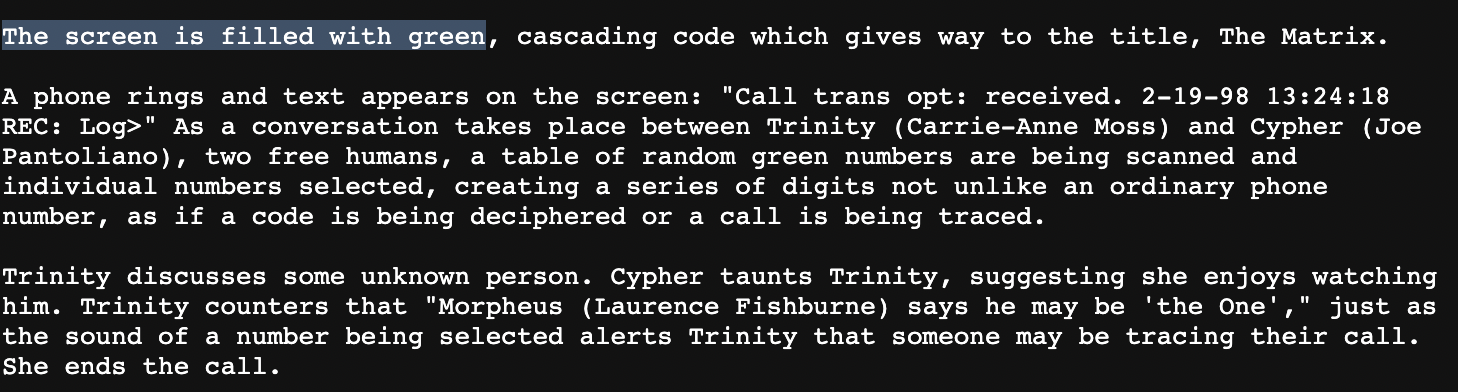

이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요.  
출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.

In [54]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
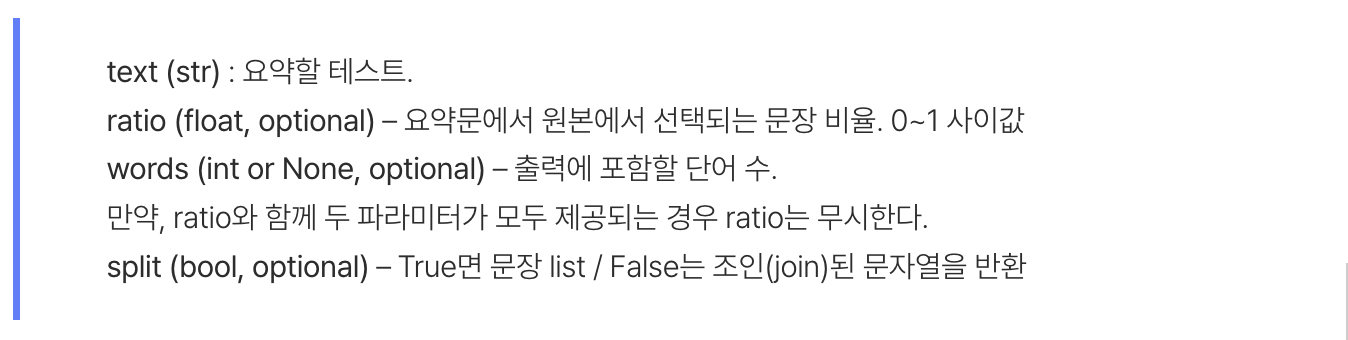

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도  
`내부적으로 문장 토큰화를 수행`  
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요.  
비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요.  
`원문의 0.005%만을 출력`하도록 설정했어요.

In [115]:
summarize??

In [55]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.

In [56]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수도 있어요.  
단어를 50개만 선택하도록 해보세요.

In [57]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
